In [1]:
from jenga.tasks.income import IncomeEstimationTask
from jenga.corruptions.generic import MissingValues
from jenga.evaluation.corruption_impact import CorruptionImpactEvaluator
import matplotlib.pyplot as plt

import numpy as np

### Instantiate the income estimation task, make it ignore incomplete records for model training

In [2]:
task = IncomeEstimationTask(seed=42, ignore_incomplete_records_for_training=True)

### A missing value imputer which imputes the most frequent value per column

In [3]:
class ModeImputer:
    def __init__(self, columns):
        self.columns = columns
        self.modes = {}
        
    def fit(self, data):
        for column in self.columns:
            mode = data[column].value_counts().index[0]
            self.modes[column] = mode
            
    def transform(self, data):
        imputed = data.copy(deep=True)
        for column in self.columns:
            imputed[column].fillna(self.modes[column], inplace=True) 
        return imputed
            
imputer = ModeImputer(['education', 'workclass', 'marital_status', 'occupation'])
imputer.fit(task.train_data)

### Some glue code (decorators) to be able to apply the imputers in our task

In [4]:
class ChainedModelDecorator:
    def __init__(self, model, imputers):
        self.model = model
        self.imputers = imputers
        
    def predict_proba(self, data):
        imputed = data
        for imputer in self.imputers:
            imputed = imputer.transform(imputed)
        
        return self.model.predict_proba(imputed)

In [5]:
class ModelDecorator:
    def __init__(self, model, imputer):
        self.model = model
        self.imputer = imputer
        
    def predict_proba(self, data):
        return self.model.predict_proba(self.imputer.transform(data))

### We generate the data corruptions to evaluate: missing values of different kinds and strengths for the columns of interest

In [6]:
evaluator = CorruptionImpactEvaluator(task)

corruptions = []
for impacted_column in ['education', 'workclass', 'marital_status', 'occupation']:
    for fraction in [0.99, 0.5, 0.25, 0.1, 0.01]:
        for missingness in ['MCAR', 'MAR', 'MNAR']:
            corruption = MissingValues(impacted_column, fraction, missingness=missingness, na_value=np.nan)
            corruptions.append(corruption)

### Train the baseline model

In [7]:
model = task.fit_baseline_model()

# TODO

In [8]:
mode_model = ModelDecorator(model, imputer)

### Evaluate the impact of the corruptions on the baseline model and the model with mode imputation

In [9]:
results = evaluator.evaluate(model, 10, *corruptions)
decorated_results = evaluator.evaluate(mode_model, 10, *corruptions)

0/600 (0.020969000000000015)
10/600 (0.17718100000000003)
20/600 (0.3846999999999996)
30/600 (0.5902329999999996)
40/600 (0.7689619999999993)
50/600 (0.9333640000000001)
60/600 (1.0935689999999996)
70/600 (1.2556849999999988)
80/600 (1.4330170000000004)
90/600 (1.6642169999999998)
100/600 (1.8333789999999999)
110/600 (2.003153)
120/600 (2.1556740000000003)
130/600 (2.307066999999999)
140/600 (2.460321999999999)
150/600 (2.6243869999999996)
160/600 (2.7566300000000004)
170/600 (2.918701999999999)
180/600 (3.0862489999999996)
190/600 (3.2254300000000002)
200/600 (3.421069)
210/600 (3.618344999999999)
220/600 (3.785946)
230/600 (3.940746)
240/600 (4.098380999999999)
250/600 (4.280361)
260/600 (4.456404999999999)
270/600 (4.609274999999999)
280/600 (4.740709)
290/600 (4.918366)
300/600 (5.114786999999999)
310/600 (5.263886)
320/600 (5.419469)
330/600 (5.610081)
340/600 (5.756958999999999)
350/600 (5.922966)
360/600 (6.227567)
370/600 (6.368768)
380/600 (6.519061)
390/600 (6.672249999999999

### Code to plot the results

In [10]:
def find_result(column, fraction, missingness, results):
    for result in results:
        corr = result.corruption
        if corr.column == column and corr.fraction == fraction and corr.sampling == missingness:
            return result

In [11]:
def plot_impact(column, plt, results, suffix=''):
    ax = plt.gca()
    
    scores = []
    labels = []

    for impacted_column in [column]:
        for fraction in [0.01, 0.1, 0.5, 0.99]:  
            for missingness in ['MNAR', 'MAR', 'MCAR']:                    
                result = find_result(impacted_column, fraction, missingness, results)
                scores.append(result.corrupted_scores)
                labels.append(f"{missingness} {int(fraction*100)}%")

    baseline_score = result.baseline_score            

    ax.axhline(baseline_score, linestyle='--', color='red')
    bplot = ax.boxplot(scores, showfliers=False, patch_artist=True, medianprops={'color':'black'})

    colors = [
        '#1e4052', '#dc6082', '#e1a677',
        '#1e4052', '#dc6082', '#e1a677', 
        '#1e4052', '#dc6082', '#e1a677', 
        '#1e4052', '#dc6082', '#e1a677'
    ]
    
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
        
    ax.yaxis.grid(True)
    ax.set_xticklabels(labels)
    
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    
    ax.set_ylim((0.79, 0.895))
    ax.set_title(f"Missing values in '{column}'", fontsize=24)
    ax.tick_params(axis='both', which='major', labelsize=22)
    ax.tick_params(axis='both', which='minor', labelsize=22)    
    ax.set_ylabel('AUC', fontsize=24)
    
    plt.gcf().set_size_inches(8, 6)
    plt.tight_layout()
    plt.show()

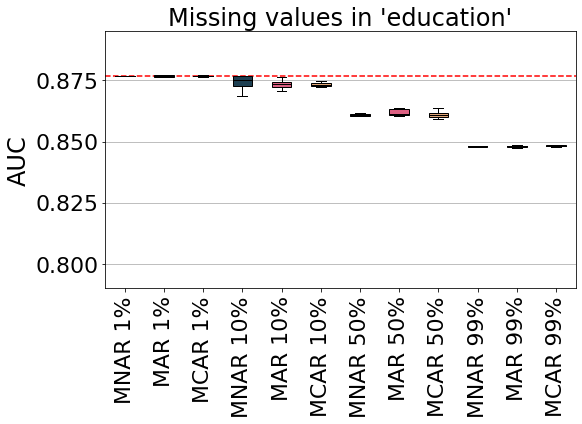

In [12]:
plot_impact('education', plt, results)

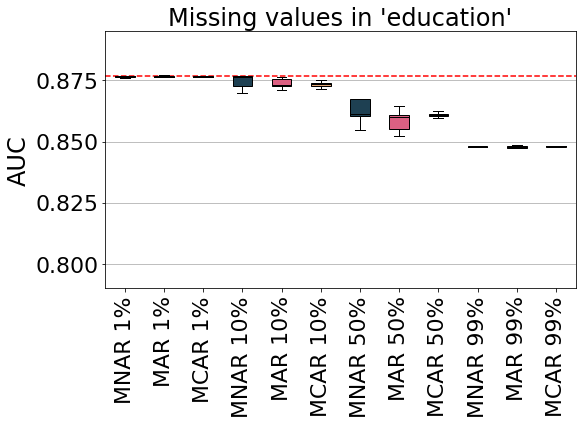

In [13]:
plot_impact('education', plt, decorated_results, '-mode')

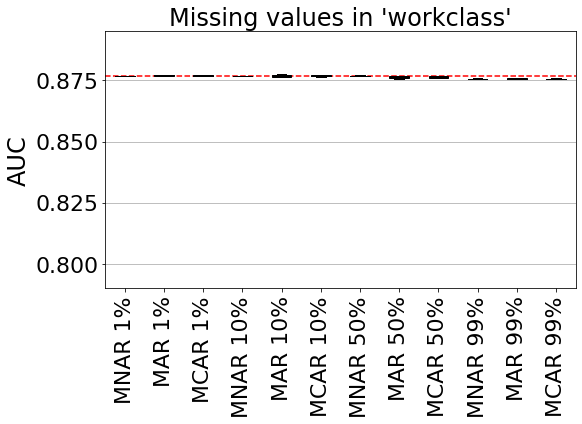

In [14]:
plot_impact('workclass', plt, results)

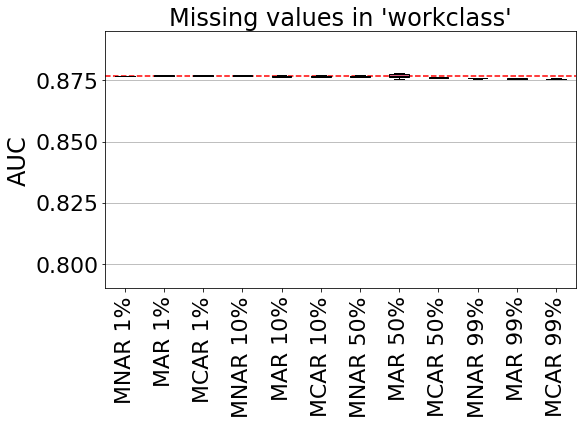

In [15]:
plot_impact('workclass', plt, decorated_results, '-mode')

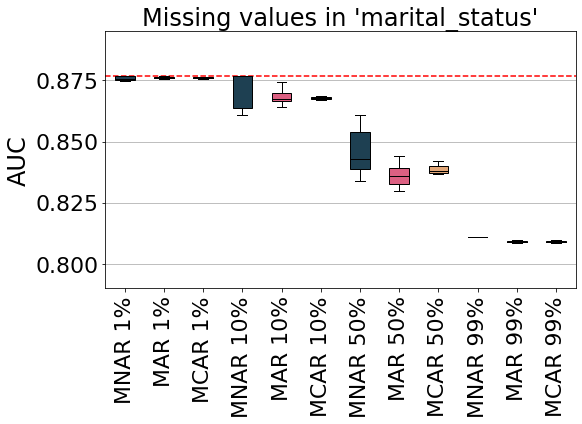

In [16]:
plot_impact('marital_status', plt, results)

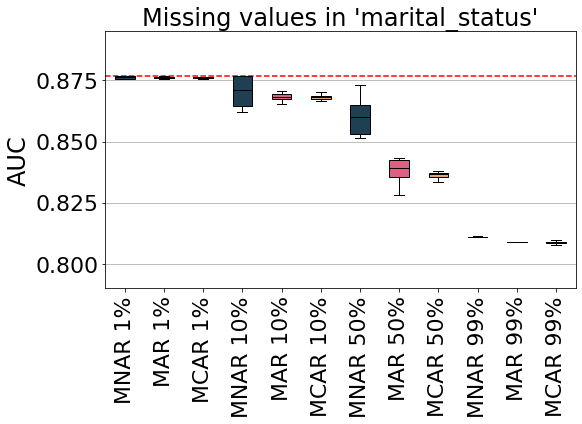

In [17]:
plot_impact('marital_status', plt, decorated_results, '-mode')

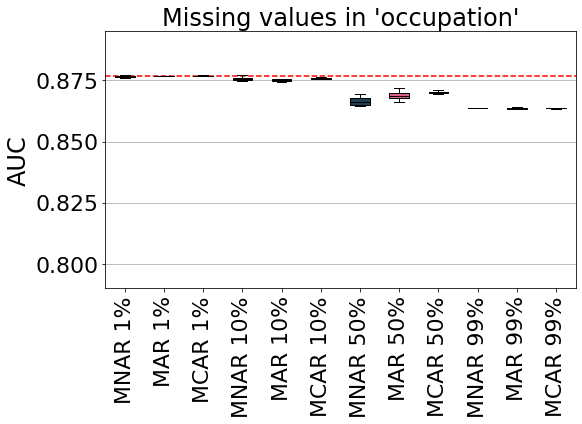

In [18]:
plot_impact('occupation', plt, results)

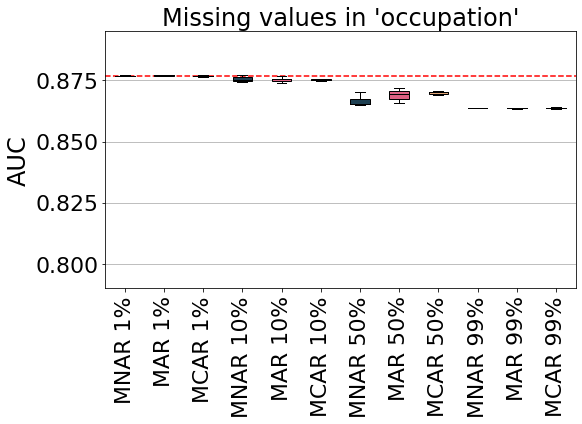

In [19]:
plot_impact('occupation', plt, decorated_results, '-mode')

### Save the results for later analysis

In [20]:
import jsonpickle
    
with open("../data/raw/mode-results.jsonpickle", "w") as text_file:
    text_file.write(jsonpickle.encode(decorated_results))    
    
with open("../data/raw/no-results.jsonpickle", "w") as text_file:
    text_file.write(jsonpickle.encode(results))        